# **Task1**

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import copy


class CharacterDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].reshape(28, 28).astype(np.uint8)
        if self.transform:
            image = self.transform(image)
        if self.labels is not None:
            return image, self.labels[idx]
        else:
            return image


def load_data(train_path, test_path, mapping_path):
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    print(f"Train data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")

    # Extract labels and features from training data
    if train_data.shape[1] == 785:
        labels = train_data.iloc[:, 0].values
        features = train_data.iloc[:, 1:].values
    else:
        raise ValueError("Training data format is incorrect. Expected 785 columns.")

    if test_data.shape[1] == 784:
        test_features = test_data.values
    elif test_data.shape[1] == 785:
        test_features = test_data.iloc[:, 1:].values
        print("Dropping the first column of test data.")
    else:
        raise ValueError(f"Test data format is incorrect. Expected 784 or 785 columns, got {test_data.shape[1]}.")

    with open(mapping_path, "r") as f:
        mappings = {int(line.split()[0]): chr(int(line.split()[1])) for line in f.readlines()}

    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)

    X_train, X_val, y_train, y_val = train_test_split(
        features, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
    )

    print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, test_features shape: {test_features.shape}")
    return X_train, X_val, y_train, y_val, test_features, mappings, le


class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_correct, val_total = 0, 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model_wts)
    return model


def evaluate_model(model, data_loader, le, has_labels=True):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in data_loader:
            if has_labels:
                images, labels = batch
                labels = labels.to(device)
                all_labels.extend(labels.cpu().numpy())
            else:
                images = batch
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())

    if has_labels:
        all_labels = np.array(all_labels)
        all_preds = np.array(all_preds)

        # Convert numerical labels to strings for the classification report
        string_classes = list(map(str, le.classes_))
        accuracy = accuracy_score(all_labels, all_preds)
        report = classification_report(all_labels, all_preds, target_names=string_classes, zero_division=1)

        print("\nClassification Report:")
        print(report)
        print(f"Accuracy: {accuracy:.4f}")

        return accuracy
    else:
        return np.array(all_preds)


def generate_predictions(model, test_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
    return np.array(all_preds)


if __name__ == "__main__":
    train_path = "../input/datasetcasestudy2/characters.csv"
    test_path = "../input/datasetcasestudy2/characters-test.csv"
    mapping_path = "../input/datasetcasestudy2/mapping.txt"

    X_train, X_val, y_train, y_val, test_data, mappings, le = load_data(train_path, test_path, mapping_path)

    transform_cnn = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    transform_resnet = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset_cnn = CharacterDataset(X_train, y_train, transform=transform_cnn)
    val_dataset_cnn = CharacterDataset(X_val, y_val, transform=transform_cnn)
    test_dataset_cnn = CharacterDataset(test_data, labels=None, transform=transform_cnn)

    train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=64, shuffle=True)
    val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=64, shuffle=False)
    test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=64, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    print("\nTraining CNN model...")
    cnn_model = CNNModel(num_classes=len(le.classes_)).to(device)
    cnn_criterion = nn.CrossEntropyLoss()
    cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

    cnn_model = train_model(cnn_model, train_loader_cnn, val_loader_cnn, cnn_criterion, cnn_optimizer, num_epochs=10, patience=3)

    print("\nEvaluating CNN Model Performance on Validation Set:")
    cnn_val_accuracy = evaluate_model(cnn_model, val_loader_cnn, le, has_labels=True)

    print("\nTraining Pre-Trained ResNet18 model...")
    pretrained_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, len(le.classes_))  # Adjust the final layer
    pretrained_model = pretrained_model.to(device)

    train_loader_resnet = DataLoader(CharacterDataset(X_train, y_train, transform=transform_resnet), batch_size=64, shuffle=True)
    val_loader_resnet = DataLoader(CharacterDataset(X_val, y_val, transform=transform_resnet), batch_size=64, shuffle=False)
    test_loader_resnet = DataLoader(CharacterDataset(test_data, labels=None, transform=transform_resnet), batch_size=64, shuffle=False)

    pretrained_criterion = nn.CrossEntropyLoss()
    pretrained_optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)

    pretrained_model = train_model(pretrained_model, train_loader_resnet, val_loader_resnet, pretrained_criterion, pretrained_optimizer, num_epochs=10, patience=3)

    print("\nEvaluating Pre-Trained ResNet18 Model Performance on Validation Set:")
    pretrained_val_accuracy = evaluate_model(pretrained_model, val_loader_resnet, le, has_labels=True)

    print("\nGenerating Predictions for Test Set...")
    cnn_test_predictions = generate_predictions(cnn_model, test_loader_cnn)
    pretrained_test_predictions = generate_predictions(pretrained_model, test_loader_resnet)

    cnn_pred_labels = le.inverse_transform(cnn_test_predictions)
    pretrained_pred_labels = le.inverse_transform(pretrained_test_predictions)

    submission_cnn = pd.DataFrame({
        'Id': range(len(cnn_pred_labels)),
        'Predicted': cnn_pred_labels
    })
    submission_cnn.to_csv('cnn_predictions.csv', index=False)
    print("CNN Predictions saved to 'cnn_predictions.csv'.")

    submission_resnet = pd.DataFrame({
        'Id': range(len(pretrained_pred_labels)),
        'Predicted': pretrained_pred_labels
    })
    submission_resnet.to_csv('resnet18_predictions.csv', index=False)
    print("Pre-Trained ResNet18 Predictions saved to 'resnet18_predictions.csv'.")

    print("\nAll processes completed successfully.")


Train data shape: (112799, 785)
Test data shape: (18799, 785)
Dropping the first column of test data.
X_train shape: (90239, 784), X_val shape: (22560, 784), test_features shape: (18799, 784)
Using device: cuda

Training CNN model...
Epoch 1/10, Loss: 2163.3513, Validation Accuracy: 0.7996
Epoch 2/10, Loss: 1565.7278, Validation Accuracy: 0.8207
Epoch 3/10, Loss: 1428.3224, Validation Accuracy: 0.8332
Epoch 4/10, Loss: 1335.0693, Validation Accuracy: 0.8411
Epoch 5/10, Loss: 1251.1767, Validation Accuracy: 0.8445
Epoch 6/10, Loss: 1174.3971, Validation Accuracy: 0.8467
Epoch 7/10, Loss: 1119.6655, Validation Accuracy: 0.8545
Epoch 8/10, Loss: 1076.1883, Validation Accuracy: 0.8584
Epoch 9/10, Loss: 1022.7336, Validation Accuracy: 0.8598
Epoch 10/10, Loss: 979.1352, Validation Accuracy: 0.8603

Evaluating CNN Model Performance on Validation Set:

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.87      0.68       480
          

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


Epoch 1/10, Loss: 619.8642, Validation Accuracy: 0.8793
Epoch 2/10, Loss: 457.3806, Validation Accuracy: 0.8721
Epoch 3/10, Loss: 406.5242, Validation Accuracy: 0.8892
Epoch 4/10, Loss: 373.3933, Validation Accuracy: 0.8913
Epoch 5/10, Loss: 339.8577, Validation Accuracy: 0.8833
Epoch 6/10, Loss: 306.7999, Validation Accuracy: 0.8926
Epoch 7/10, Loss: 275.9120, Validation Accuracy: 0.8975
Epoch 8/10, Loss: 247.6243, Validation Accuracy: 0.8911
Epoch 9/10, Loss: 217.5838, Validation Accuracy: 0.8949
Epoch 10/10, Loss: 191.2893, Validation Accuracy: 0.8935
Early stopping triggered.

Evaluating Pre-Trained ResNet18 Model Performance on Validation Set:

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       480
           1       0.57      0.71      0.63       480
           2       0.95      0.88      0.91       480
           3       0.99      0.98      0.98       480
           4       0.95      0.95      0.95     

# **Taks 2**

Number of training samples: 830
Number of testing samples: 243

--- Baseline LSTM Model (Random Embeddings) ---


Epoch 1/15: 100%|██████████| 26/26 [00:00<00:00, 141.91it/s]


Epoch [1/15], Loss: 0.6940


Epoch 2/15: 100%|██████████| 26/26 [00:00<00:00, 206.00it/s]


Epoch [2/15], Loss: 0.6929


Epoch 3/15: 100%|██████████| 26/26 [00:00<00:00, 241.38it/s]


Epoch [3/15], Loss: 0.6812


Epoch 4/15: 100%|██████████| 26/26 [00:00<00:00, 248.51it/s]


Epoch [4/15], Loss: 0.6243


Epoch 5/15: 100%|██████████| 26/26 [00:00<00:00, 252.83it/s]


Epoch [5/15], Loss: 0.5770


Epoch 6/15: 100%|██████████| 26/26 [00:00<00:00, 243.85it/s]


Epoch [6/15], Loss: 0.4845


Epoch 7/15: 100%|██████████| 26/26 [00:00<00:00, 243.22it/s]


Epoch [7/15], Loss: 0.4562


Epoch 8/15: 100%|██████████| 26/26 [00:00<00:00, 249.04it/s]


Epoch [8/15], Loss: 0.4333


Epoch 9/15: 100%|██████████| 26/26 [00:00<00:00, 250.35it/s]


Epoch [9/15], Loss: 0.3291


Epoch 10/15: 100%|██████████| 26/26 [00:00<00:00, 249.75it/s]


Epoch [10/15], Loss: 0.2999


Epoch 11/15: 100%|██████████| 26/26 [00:00<00:00, 244.53it/s]


Epoch [11/15], Loss: 0.2814


Epoch 12/15: 100%|██████████| 26/26 [00:00<00:00, 237.01it/s]


Epoch [12/15], Loss: 0.2554


Epoch 13/15: 100%|██████████| 26/26 [00:00<00:00, 249.48it/s]


Epoch [13/15], Loss: 0.4620


Epoch 14/15: 100%|██████████| 26/26 [00:00<00:00, 250.78it/s]


Epoch [14/15], Loss: 0.4279


Epoch 15/15: 100%|██████████| 26/26 [00:00<00:00, 251.34it/s]


Epoch [15/15], Loss: 0.3235

--- Evaluating Baseline LSTM Model ---
Baseline LSTM Model Test Accuracy: 53.09%
Classification Report:
              precision    recall  f1-score   support

         OBJ       0.50      0.89      0.64       116
        SUBJ       0.67      0.20      0.31       127

    accuracy                           0.53       243
   macro avg       0.59      0.55      0.48       243
weighted avg       0.59      0.53      0.47       243

Confusion Matrix:
[[103  13]
 [101  26]]

--- Transfer Learning LSTM Model (Using GloVe) ---
Loading GloVe embeddings...


Epoch 1/15: 100%|██████████| 26/26 [00:00<00:00, 151.50it/s]


Epoch [1/15], Loss: 0.6937


Epoch 2/15: 100%|██████████| 26/26 [00:00<00:00, 189.74it/s]


Epoch [2/15], Loss: 0.6584


Epoch 3/15: 100%|██████████| 26/26 [00:00<00:00, 234.90it/s]


Epoch [3/15], Loss: 0.5964


Epoch 4/15: 100%|██████████| 26/26 [00:00<00:00, 239.25it/s]


Epoch [4/15], Loss: 0.5522


Epoch 5/15: 100%|██████████| 26/26 [00:00<00:00, 239.76it/s]


Epoch [5/15], Loss: 0.4916


Epoch 6/15: 100%|██████████| 26/26 [00:00<00:00, 251.27it/s]


Epoch [6/15], Loss: 0.4942


Epoch 7/15: 100%|██████████| 26/26 [00:00<00:00, 245.45it/s]


Epoch [7/15], Loss: 0.3353


Epoch 8/15: 100%|██████████| 26/26 [00:00<00:00, 236.79it/s]


Epoch [8/15], Loss: 0.2631


Epoch 9/15: 100%|██████████| 26/26 [00:00<00:00, 239.30it/s]


Epoch [9/15], Loss: 0.1864


Epoch 10/15: 100%|██████████| 26/26 [00:00<00:00, 234.52it/s]


Epoch [10/15], Loss: 0.0867


Epoch 11/15: 100%|██████████| 26/26 [00:00<00:00, 237.56it/s]


Epoch [11/15], Loss: 0.0696


Epoch 12/15: 100%|██████████| 26/26 [00:00<00:00, 228.14it/s]


Epoch [12/15], Loss: 0.0458


Epoch 13/15: 100%|██████████| 26/26 [00:00<00:00, 245.48it/s]


Epoch [13/15], Loss: 0.0320


Epoch 14/15: 100%|██████████| 26/26 [00:00<00:00, 244.10it/s]


Epoch [14/15], Loss: 0.0103


Epoch 15/15: 100%|██████████| 26/26 [00:00<00:00, 227.65it/s]


Epoch [15/15], Loss: 0.0044

--- Evaluating Transfer Learning LSTM Model ---
Transfer Learning LSTM Model Test Accuracy: 55.97%
Classification Report:
              precision    recall  f1-score   support

         OBJ       0.52      0.91      0.66       116
        SUBJ       0.75      0.24      0.36       127

    accuracy                           0.56       243
   macro avg       0.64      0.58      0.51       243
weighted avg       0.64      0.56      0.51       243

Confusion Matrix:
[[106  10]
 [ 97  30]]


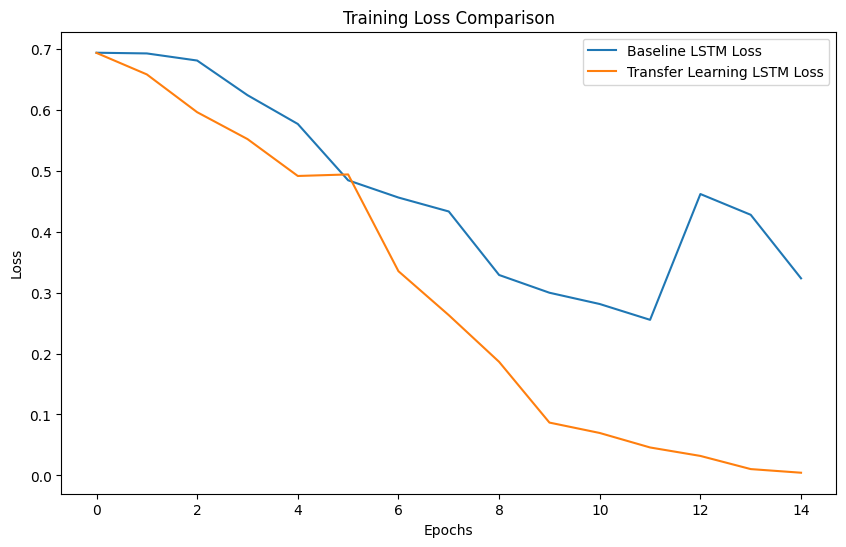

In [25]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

train_file_path = '../input/datasetcasestudy2/train.tsv'
test_file_path = '../input/datasetcasestudy2/test.tsv'

train_data = pd.read_csv(train_file_path, sep='\t')
test_data = pd.read_csv(test_file_path, sep='\t')

print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")

max_vocab_size = 10000
max_length = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def tokenize(text):
    return text.split()

vocab_counter = Counter()
for sentence in train_data['sentence']:
    vocab_counter.update(tokenize(sentence))

vocab = {word: idx + 1 for idx, (word, _) in enumerate(vocab_counter.most_common(max_vocab_size - 1))}
vocab["<PAD>"] = 0
vocab["<OOV>"] = len(vocab)

def encode_sentence(sentence, vocab, max_length):
    tokens = [vocab.get(word, vocab["<OOV>"]) for word in tokenize(sentence)]
    if len(tokens) < max_length:
        tokens += [vocab["<PAD>"]] * (max_length - len(tokens))
    return tokens[:max_length]

X_train = np.array([encode_sentence(sentence, vocab, max_length) for sentence in train_data['sentence']])
X_test = np.array([encode_sentence(sentence, vocab, max_length) for sentence in test_data['sentence']])

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])
y_test = label_encoder.transform(test_data['label'])
num_classes = len(label_encoder.classes_)

class TextDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = torch.tensor(sentences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx]

train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, embedding_matrix=None):
        super(LSTMClassifier, self).__init__()
        if embedding_matrix is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        hidden = lstm_out.mean(dim=1)
        out = self.fc(hidden)
        return out

def train_model(model, train_loader, num_epochs=10, lr=0.001):
    class_weights = torch.tensor([len(y_train) / Counter(y_train)[i] for i in range(num_classes)], dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for sentences, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            sentences, labels = sentences.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(sentences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")
    return train_losses

def evaluate_model(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for sentences, labels in data_loader:
            sentences, labels = sentences.to(device), labels.to(device)
            outputs = model(sentences)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

print("\n--- Baseline LSTM Model (Random Embeddings) ---")
baseline_model = LSTMClassifier(vocab_size=len(vocab), embedding_dim=100, hidden_dim=128, num_classes=num_classes).to(device)
baseline_train_losses = train_model(baseline_model, train_loader, num_epochs=15, lr=0.001)

print("\n--- Evaluating Baseline LSTM Model ---")
y_true_baseline, y_pred_baseline = evaluate_model(baseline_model, test_loader)
accuracy_baseline = accuracy_score(y_true_baseline, y_pred_baseline)
print(f"Baseline LSTM Model Test Accuracy: {accuracy_baseline * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_true_baseline, y_pred_baseline, target_names=label_encoder.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_true_baseline, y_pred_baseline))

print("\n--- Transfer Learning LSTM Model (Using GloVe) ---")
print("Loading GloVe embeddings...")
glove_file_path = '../input/datasetcasestudy2/glove.6B.100d.txt'
embedding_dim = 100
embedding_matrix = np.zeros((len(vocab), embedding_dim))

with open(glove_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        idx = vocab.get(word)
        if idx is not None:
            embedding_matrix[idx] = vector

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float)

transfer_model = LSTMClassifier(vocab_size=len(vocab), embedding_dim=embedding_dim, hidden_dim=128, num_classes=num_classes, embedding_matrix=embedding_matrix).to(device)
transfer_train_losses = train_model(transfer_model, train_loader, num_epochs=15, lr=0.001)

print("\n--- Evaluating Transfer Learning LSTM Model ---")
y_true_transfer, y_pred_transfer = evaluate_model(transfer_model, test_loader)
accuracy_transfer = accuracy_score(y_true_transfer, y_pred_transfer)
print(f"Transfer Learning LSTM Model Test Accuracy: {accuracy_transfer * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_true_transfer, y_pred_transfer, target_names=label_encoder.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_true_transfer, y_pred_transfer))

plt.figure(figsize=(10, 6))
plt.plot(baseline_train_losses, label='Baseline LSTM Loss')
plt.plot(transfer_train_losses, label='Transfer Learning LSTM Loss')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **Hyperparameter Tuning**

In [2]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

import ray
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch

from ray.air import session

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  
device = torch.device("cpu")
print(f"Using device: {device}")

ray.init(local_mode=True, ignore_reinit_error=True)

train_file_path = '../input/datasetcasestudy2/train.tsv'
test_file_path = '../input/datasetcasestudy2/test.tsv'

try:
    train_data = pd.read_csv(train_file_path, sep='\t')
    test_data = pd.read_csv(test_file_path, sep='\t')
except FileNotFoundError as e:
    print("Check if your file paths are correct!")
    raise e

print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")

max_vocab_size = 10000  
max_length = 100        

def tokenize(text):
    return text.split()  

from collections import Counter
vocab_counter = Counter()
for sentence in train_data['sentence']:
    vocab_counter.update(tokenize(sentence))

vocab = {word: idx + 1 for idx, (word, _) in enumerate(vocab_counter.most_common(max_vocab_size - 1))}
vocab["<PAD>"] = 0
vocab["<OOV>"] = len(vocab)  

def encode_sentence(sentence, vocab, max_length):
    tokens = [vocab.get(word, vocab["<OOV>"]) for word in tokenize(sentence)]
    if len(tokens) < max_length:
        tokens += [vocab["<PAD>"]] * (max_length - len(tokens))
    return tokens[:max_length]

X_train = np.array([encode_sentence(s, vocab, max_length) for s in train_data['sentence']])
X_test = np.array([encode_sentence(s, vocab, max_length) for s in test_data['sentence']])

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])
y_test = label_encoder.transform(test_data['label'])
num_classes = len(label_encoder.classes_)

class TextDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = torch.tensor(sentences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx]

train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

glove_file_path = '../input/datasetcasestudy2/glove.6B.100d.txt'
embedding_dim = 100  
embedding_matrix = np.zeros((len(vocab), embedding_dim), dtype=np.float32)

try:
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            idx = vocab.get(word)
            if idx is not None:
                embedding_matrix[idx] = vector
except FileNotFoundError as e:
    print("Check if your GloVe file path is correct!")
    raise e

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float)

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes,
                 embedding_matrix=None, trainable_embedding=True):
        super(LSTMClassifier, self).__init__()
        fixed_embedding_dim = embedding_matrix.shape[1] 

        if embedding_matrix is not None:
            self.embedding = nn.Embedding.from_pretrained(
                embedding_matrix, freeze=not trainable_embedding
            )
        else:
            self.embedding = nn.Embedding(vocab_size, fixed_embedding_dim)

        self.lstm = nn.LSTM(fixed_embedding_dim, hidden_dim,
                            num_layers=2, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        hidden = lstm_out[:, -1, :]  
        out = self.fc(hidden)
        return out

def train_model(config):
  
    model = LSTMClassifier(
        vocab_size=len(vocab),
        hidden_dim=config["hidden_dim"],
        num_classes=num_classes,
        embedding_matrix=embedding_matrix,
        trainable_embedding=config["trainable_embedding"]
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    epochs = config["epochs"]

    for epoch in range(epochs):
        # Training loop
        model.train()
        for sentences, labels in train_loader:
            sentences, labels = sentences.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(sentences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for sentences, labels in test_loader:
                sentences, labels = sentences.to(device), labels.to(device)
                outputs = model(sentences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        session.report({"val_loss": val_loss})

search_space = {
    "hidden_dim": tune.choice([32, 64, 128]),
    "lr": tune.loguniform(1e-5, 1e-3),
    "trainable_embedding": tune.choice([True, False]),
    "epochs": 5  
}

analysis = tune.run(
    train_model,
    config=search_space,
    metric="val_loss",
    mode="min",
    num_samples=2,           
    search_alg=HyperOptSearch(),
    resources_per_trial={"cpu": 1, "gpu": 0},
)

best_trial = analysis.get_best_trial("val_loss", "min", "last")
print("\nBest Hyperparameters:", best_trial.config)

def train_and_evaluate(config):
  
    model = LSTMClassifier(
        vocab_size=len(vocab),
        hidden_dim=config["hidden_dim"],
        num_classes=num_classes,
        embedding_matrix=embedding_matrix,
        trainable_embedding=config["trainable_embedding"]
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    epochs = config["epochs"]

    # Train loop
    for epoch in range(epochs):
        model.train()
        for sentences, labels in train_loader:
            sentences, labels = sentences.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(sentences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sentences, labels in test_loader:
            sentences, labels = sentences.to(device), labels.to(device)
            outputs = model(sentences)
            _, predicted = torch.max(outputs, 1)  # argmax
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

best_config = best_trial.config

test_accuracy = train_and_evaluate(best_config)
print(f"\nTest Accuracy with best hyperparams: {test_accuracy:.4f}")


Using device: cpu


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2025-01-08 17:04:00,367	INFO worker.py:1821 -- Started a local Ray instance.


Number of training samples: 830
Number of testing samples: 243


2025-01-08 17:04:09,315	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2025-01-08 17:04:09,390	INFO tensorboardx.py:193 -- pip install "ray[tune]" to see TensorBoard files.
2025-01-08 17:04:09,391	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


:job_id:01000000
:task_name:bundle_reservation_check_func


:job_id:01000000
:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:train_model


:actor_name:ImplicitFunc
:actor_name:train_model


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:train_model


:task_name:bundle_reservation_check_func
:actor_name:ImplicitFunc
:actor_name:train_model


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


2025-01-08 17:04:18,378	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_2025-01-08_17-04-09' in 0.0059s.
2025-01-08 17:04:18,382	INFO tune.py:1041 -- Total run time: 9.07 seconds (8.95 seconds for the tuning loop).


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>

Best Hyperparameters: {'hidden_dim': 32, 'lr': 0.0002691436008880672, 'trainable_embedding': True, 'epochs': 5}

Test Accuracy with best hyperparams: 0.4774
